## Data Preparation

In [ ]:
#@title Install SHAP
#!pip install shap

In [ ]:
#@title Data and Library Imports
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numbers
import ast
import itertools
import plotly.express as px
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

train_ac = pd.read_csv('/content/drive/MyDrive/sakai/old_version/train_acoustic.csv')
train_fl = pd.read_csv('/content/drive/MyDrive/sakai/old_version/train_fluency.csv')
train_li = pd.read_csv('/content/drive/MyDrive/sakai/old_version/train_linguistic.csv')
test_ac = pd.read_csv('/content/drive/MyDrive/sakai/test_acoustic.csv')
test_fl = pd.read_csv('/content/drive/MyDrive/sakai/test_fluency.csv')
test_li = pd.read_csv('/content/drive/MyDrive/sakai/test_linguistic.csv')

train_main = pd.read_csv('/content/drive/MyDrive/Summer 2024/IGSA Work/groundtruth_lan (1).csv')
train_main['tkdname'] = ['./data/TAUKADIAL-24/train/' + i for i in train_main['tkdname']]
test_main = pd.read_csv('/content/drive/MyDrive/Summer 2024/IGSA Work/testgroundtruth.csv', sep = ';')
test_main['tkdname'] = ['./data/TAUKADIAL-24/test/' + i for i in test_main['tkdname']]

In [ ]:
#@title Assemble Training Dataframe

#merge data frames into one large df
train_df = train_main.merge(train_ac, left_on = 'tkdname', right_on = 'File', how = 'outer').drop('File', axis = 1).drop('target', axis = 1)
train_df = train_df.merge(train_fl, left_on = 'tkdname', right_on = 'File', how = 'outer').drop('File', axis = 1).drop('target', axis = 1)
train_df = train_df.merge(train_li, left_on = 'tkdname', right_on = 'File', how = 'outer').drop('File', axis = 1).drop('target', axis = 1)
train_df = train_df.drop(['Filler Rate', 'Speaking Rate'], axis = 1)
train_df['dx'] = [1 if i == 'MCI' else 0 for i in train_df['dx']]
train_df

,tkdname,age,sex,mmse,dx,lan,Total Duration,Mean Pitch,Jitter,Shimmer,...,Repetition Frequency,Unique Word Count,Invented Word Count,Total Adjectives,Total Adverbs,Total Nouns,Total Verbs,Total Pronouns,Total Conjunction,Depth of Syntax Tree
0,./data/TAUKADIAL-24/train/taukdial-002-1.wav,72,F,29,0,E,122.440000,164.242554,0.017773,0.088550,...,0.000000,83,52,21,9,68,59,39,15,2
1,./data/TAUKADIAL-24/train/taukdial-002-2.wav,72,F,29,0,E,45.660000,162.687280,0.021281,0.098618,...,0.000000,45,23,3,8,31,29,7,7,2
2,./data/TAUKADIAL-24/train/taukdial-002-3.wav,72,F,29,0,E,62.690000,179.818570,0.021813,0.098348,...,0.000000,43,37,4,4,30,35,14,5,2
3,./data/TAUKADIAL-24/train/taukdial-003-1.wav,80,M,23,1,C,21.691521,111.579973,0.017167,0.098349,...,0.000000,5,9,5,0,2,13,0,0,2
4,./data/TAUKADIAL-24/train/taukdial-003-2.wav,80,M,23,1,C,29.917625,114.257428,0.023902,0.140785,...,0.000000,3,7,1,1,4,8,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,./data/TAUKADIAL-24/train/taukdial-167-2.wav,65,F,29,0,E,67.825000,177.571654,0.016614,0.089693,...,0.006993,46,22,2,9,29,28,9,8,2
383,./data/TAUKADIAL-24/train/taukdial-167-3.wav,65,F,29,0,E,24.010000,168.297565,0.018833,0.106917,...,0.000000,29,21,1,1,14,17,5,1,2
384,./data/TAUKADIAL-24/train/taukdial-169-1.wav,81,F,28,1,E,164.630000,170.868426,0.026821,0.136527,...,0.000000,84,102,22,24,70,75,34,14,2
385,./data/TAUKADIAL-24/train/taukdial-169-2.wav,81,F,28,1,E,52.680000,189.802745,0.030210,0.135562,...,0.000000,27,10,4,1,13,17,3,5,2


In [ ]:
#@title Assemble Testing Dataframe

#merge data frames into one large df
test_df = test_main.merge(test_ac, left_on = 'tkdname', right_on = 'File', how = 'outer').drop('File', axis = 1)
test_df = test_df.merge(test_fl, left_on = 'tkdname', right_on = 'File', how = 'outer').drop('File', axis = 1)
test_df = test_df.merge(test_li, left_on = 'tkdname', right_on = 'File', how = 'outer').drop('File', axis = 1)
test_df = test_df.drop(['Filler Rate', 'Speaking Rate'], axis = 1)
test_df['dx'] = [1 if i == 'MCI' else 0 for i in test_df['dx']]
test_df

,tkdname,mmse,dx,Total Duration,Mean Pitch,Jitter,Shimmer,General Silence,Mean Silence,Silence Abs Deviation,...,Repetition Frequency,Unique Word Count,Invented Word Count,Total Adjectives,Total Adverbs,Total Nouns,Total Verbs,Total Pronouns,Total Conjunction,Depth of Syntax Tree
0,./data/TAUKADIAL-24/test/taukdial-001-1.wav,27,0,17.894021,322.925659,0.050469,0.233603,1,0.010667,0.000000,...,0.0,10,20,4,2,7,14,4,0,2
1,./data/TAUKADIAL-24/test/taukdial-001-2.wav,27,0,19.141021,386.835780,0.077055,0.246705,0,0.000000,0.000000,...,0.0,10,13,3,3,5,22,0,0,2
2,./data/TAUKADIAL-24/test/taukdial-001-3.wav,27,0,22.482250,435.241625,0.076236,0.237734,0,0.000000,0.000000,...,0.0,4,31,0,63,64,63,0,0,2
3,./data/TAUKADIAL-24/test/taukdial-010-1.wav,27,1,47.470000,163.695541,0.030779,0.142280,48,0.172000,0.156167,...,0.0,47,27,13,13,27,32,7,14,2
4,./data/TAUKADIAL-24/test/taukdial-010-2.wav,27,1,29.330000,170.702101,0.028463,0.139954,39,0.160821,0.143989,...,0.0,29,14,1,2,17,18,7,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,./data/TAUKADIAL-24/test/taukdial-166-2.wav,28,1,57.910000,174.392947,0.026509,0.144390,30,0.806400,0.562347,...,0.0,28,15,4,7,21,30,8,7,2
116,./data/TAUKADIAL-24/test/taukdial-166-3.wav,28,1,40.190000,182.735181,0.022918,0.120985,26,0.793846,0.764876,...,0.0,23,14,1,2,15,10,3,2,2
117,./data/TAUKADIAL-24/test/taukdial-168-1.wav,29,0,113.081167,107.070285,0.024537,0.098584,166,0.428466,0.433658,...,0.0,19,35,12,6,32,27,6,13,2
118,./data/TAUKADIAL-24/test/taukdial-168-2.wav,29,0,139.926437,107.509813,0.024251,0.103465,180,0.517215,0.584536,...,0.0,27,33,8,11,51,41,20,13,2


In [ ]:
#@title Drop Non-Training Columns (besides name)
train_df = train_df.drop(['age', 'sex', 'lan', 'Depth of Syntax Tree'], axis = 1)
test_df = test_df.drop(['Depth of Syntax Tree'], axis = 1)
train_df

,tkdname,mmse,dx,Total Duration,Mean Pitch,Jitter,Shimmer,General Silence,Mean Silence,Silence Abs Deviation,...,Word syllables 2,Repetition Frequency,Unique Word Count,Invented Word Count,Total Adjectives,Total Adverbs,Total Nouns,Total Verbs,Total Pronouns,Total Conjunction
0,./data/TAUKADIAL-24/train/taukdial-002-1.wav,29,0,122.440000,164.242554,0.017773,0.088550,114,0.313544,0.319138,...,14,0.000000,83,52,21,9,68,59,39,15
1,./data/TAUKADIAL-24/train/taukdial-002-2.wav,29,0,45.660000,162.687280,0.021281,0.098618,56,0.197143,0.202367,...,8,0.000000,45,23,3,8,31,29,7,7
2,./data/TAUKADIAL-24/train/taukdial-002-3.wav,29,0,62.690000,179.818570,0.021813,0.098348,35,0.733257,0.874998,...,4,0.000000,43,37,4,4,30,35,14,5
3,./data/TAUKADIAL-24/train/taukdial-003-1.wav,23,1,21.691521,111.579973,0.017167,0.098349,27,0.312099,0.305310,...,0,0.000000,5,9,5,0,2,13,0,0
4,./data/TAUKADIAL-24/train/taukdial-003-2.wav,23,1,29.917625,114.257428,0.023902,0.140785,108,0.152198,0.108852,...,0,0.000000,3,7,1,1,4,8,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,./data/TAUKADIAL-24/train/taukdial-167-2.wav,29,0,67.825000,177.571654,0.016614,0.089693,70,0.400000,0.462629,...,6,0.006993,46,22,2,9,29,28,9,8
383,./data/TAUKADIAL-24/train/taukdial-167-3.wav,29,0,24.010000,168.297565,0.018833,0.106917,37,0.165189,0.145952,...,4,0.000000,29,21,1,1,14,17,5,1
384,./data/TAUKADIAL-24/train/taukdial-169-1.wav,28,1,164.630000,170.868426,0.026821,0.136527,132,0.589091,0.589686,...,19,0.000000,84,102,22,24,70,75,34,14
385,./data/TAUKADIAL-24/train/taukdial-169-2.wav,28,1,52.680000,189.802745,0.030210,0.135562,37,0.795676,0.838264,...,5,0.000000,27,10,4,1,13,17,3,5


In [ ]:
#@title Get split indices
with open('/content/drive/MyDrive/Summer 2024/IGSA Work/split.txt','r') as f:
  split = f.readlines()
split = [ast.literal_eval(x.replace('\n','')) for x in split if x != '\n']

#index 0 of the train_idx contains none of the values in index 0 of test_idx

train_idx = []
test_idx = []
group_ids = [0,1,2,3,4]
for id in group_ids:
  train_idx.append(split[2*id])
  test_idx.append(split[2*id + 1])

print(train_idx)
print(test_idx)

[['002', '003', '004', '005', '007', '008', '009', '011', '014', '021', '023', '024', '025', '026', '027', '032', '035', '037', '038', '039', '040', '045', '046', '047', '050', '051', '052', '053', '056', '057', '063', '065', '066', '067', '068', '070', '071', '072', '073', '074', '076', '077', '078', '079', '083', '085', '086', '088', '089', '090', '091', '093', '094', '095', '096', '098', '099', '100', '101', '102', '104', '105', '106', '107', '108', '111', '112', '115', '116', '117', '118', '120', '121', '122', '124', '126', '128', '130', '131', '134', '136', '137', '138', '140', '141', '142', '143', '144', '145', '148', '149', '153', '154', '156', '157', '159', '160', '161', '162', '164', '165', '167', '169'], ['003', '004', '005', '006', '007', '008', '009', '011', '015', '020', '023', '024', '026', '027', '030', '031', '032', '035', '038', '041', '044', '046', '048', '050', '052', '053', '054', '056', '057', '063', '064', '065', '067', '069', '070', '072', '073', '074', '076', '0

In [ ]:
#@title Create new dataframe w/ patient labels

train_test_df = pd.concat([train_df,test_df], ignore_index = True)

#train_test_df['question'] = [int(name.split('/taukdial-')[1].split('-')[1][0]) for name in train_test_df['tkdname']]
train_test_df['tkdname'] = [name.split('/taukdial-')[1].split('-')[0] for name in train_test_df['tkdname']]

train_test_df

,tkdname,mmse,dx,Total Duration,Mean Pitch,Jitter,Shimmer,General Silence,Mean Silence,Silence Abs Deviation,...,Word syllables 2,Repetition Frequency,Unique Word Count,Invented Word Count,Total Adjectives,Total Adverbs,Total Nouns,Total Verbs,Total Pronouns,Total Conjunction
0,002,29,0,122.440000,164.242554,0.017773,0.088550,114,0.313544,0.319138,...,14,0.0,83,52,21,9,68,59,39,15
1,002,29,0,45.660000,162.687280,0.021281,0.098618,56,0.197143,0.202367,...,8,0.0,45,23,3,8,31,29,7,7
2,002,29,0,62.690000,179.818570,0.021813,0.098348,35,0.733257,0.874998,...,4,0.0,43,37,4,4,30,35,14,5
3,003,23,1,21.691521,111.579973,0.017167,0.098349,27,0.312099,0.305310,...,0,0.0,5,9,5,0,2,13,0,0
4,003,23,1,29.917625,114.257428,0.023902,0.140785,108,0.152198,0.108852,...,0,0.0,3,7,1,1,4,8,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,166,28,1,57.910000,174.392947,0.026509,0.144390,30,0.806400,0.562347,...,0,0.0,28,15,4,7,21,30,8,7
503,166,28,1,40.190000,182.735181,0.022918,0.120985,26,0.793846,0.764876,...,0,0.0,23,14,1,2,15,10,3,2
504,168,29,0,113.081167,107.070285,0.024537,0.098584,166,0.428466,0.433658,...,2,0.0,19,35,12,6,32,27,6,13
505,168,29,0,139.926437,107.509813,0.024251,0.103465,180,0.517215,0.584536,...,12,0.0,27,33,8,11,51,41,20,13


## Model training and evaluation

In [ ]:
model_list = ["LogisticRegression()", "LogisticRegression(penalty = 'l1', solver = 'liblinear')", "RandomForestClassifier()","svm.SVC()"]
model_list[3] = "svm.SVC(kernel = 'linear')"

imp_str_list = ['.coef_[0]' if 'RandomForestClassifier' not in i else '.feature_importances_' for i in model_list]
imp_str_list

['.coef_[0]', '.coef_[0]', '.feature_importances_', '.coef_[0]']

In [ ]:
#@title Train-test loop 1 function: no repeats in training data (aggregating training data and making a single prediction per patient)

def train_test_loop1(model_type_str, train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #aggregate training features and put them into a dictionary
    train_agg_dict, test_agg_dict = {}, {}

    for id in train_unique_ids:
      train_id_df = train_df_idx[train_df_idx['tkdname'] == id].drop(['tkdname'], axis = 1)
      for col in train_id_df.columns:
        if col != 'dx':
          if ('Mean ' + col) not in train_agg_dict:
            train_agg_dict['Mean ' + col] = []
          train_agg_dict['Mean ' + col].append(np.mean(train_id_df[col]))
        else:
          if col not in train_agg_dict:
            train_agg_dict[col] = []
          train_agg_dict['dx'].append(int(round(np.mean(train_id_df[col]))))

    for id in test_unique_ids:
      test_id_df = test_df_idx[test_df_idx['tkdname'] == id].drop(['tkdname'], axis = 1)
      for col in test_id_df.columns:
        if col != 'dx':
          if ('Mean ' + col) not in test_agg_dict:
            test_agg_dict['Mean ' + col] = []
          test_agg_dict['Mean ' + col].append(np.mean(test_id_df[col]))
        else:
          if col not in test_agg_dict:
            test_agg_dict[col] = []
          test_agg_dict['dx'].append(int(round(np.mean(test_id_df[col]))))

    train_agg_df, test_agg_df = pd.DataFrame(train_agg_dict), pd.DataFrame(test_agg_dict)

    #train a model to predict 'dx'

    X_train = train_agg_df.drop(['dx'], axis = 1)
    y_train = train_agg_df['dx']
    X_test = test_agg_df.drop(['dx'], axis = 1)
    y_test = test_agg_df['dx']

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = eval(model_type_str).fit(X_train, y_train)
    preds = model.predict(X_test)

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)
  #return best_model
  return best_model, scores

LogisticRegression()
{'mean accuracy': 0.7597, 'mean precision': 0.7789, 'mean recall': 0.8132, 'mean f1': 0.7902}
LogisticRegression(penalty = 'l1', solver = 'liblinear')
{'mean accuracy': 0.7822, 'mean precision': 0.8286, 'mean recall': 0.794, 'mean f1': 0.8066}
RandomForestClassifier()
{'mean accuracy': 0.7286, 'mean precision': 0.7593, 'mean recall': 0.8057, 'mean f1': 0.7685}
svm.SVC(kernel = 'linear')
{'mean accuracy': 0.7751, 'mean precision': 0.8073, 'mean recall': 0.7978, 'mean f1': 0.7995}


(0.6, 0.9)

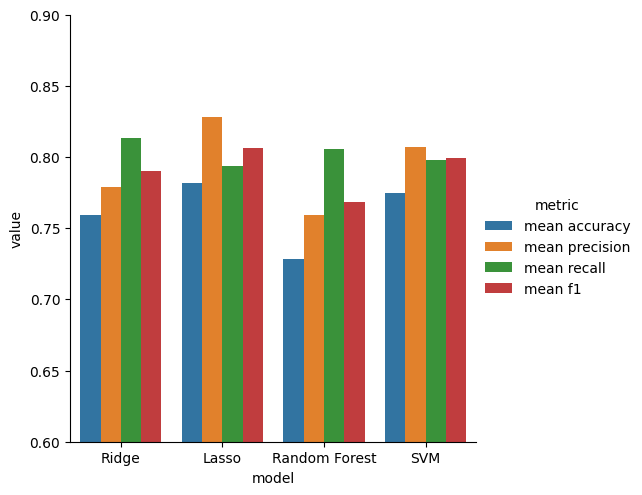

In [ ]:
#@title PLOTS: Train-test loop 1 performances w/ different models
#only works if train_test_loop returns metric values
stat_list = ['mean accuracy', 'mean precision', 'mean recall', 'mean f1']
stat_df = pd.DataFrame(columns = stat_list)
for i in model_list:
  print(i)
  dic = train_test_loop1(i, train_test_df, train_idx, test_idx)[1]
  stat_df.loc[len(stat_df)] = dic
stat_df['model'] = ['Ridge', 'Lasso', 'Random Forest', 'SVM']


# Melt the DataFrame to long format
stat_df = pd.melt(stat_df, id_vars=['model'], value_vars=stat_list,
                  var_name='metric', value_name='value')

sns.catplot(stat_df, x = 'model', y = 'value', kind = 'bar', hue = 'metric')
plt.ylim(0.6,0.9)

In [ ]:
#@title OLD: Train-test loop 1 performances w/ different models
# for i in model_list:
#   print(i)
#   train_test_loop1(i, train_test_df, train_idx, test_idx)

In [ ]:
#@title Train-test loop 2 function: no repeats in training data (aggregating multiple predictions for each patient)

def train_test_loop2(model_type_str, train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #train a model to predict 'dx'

    X_train = train_df_idx.drop(['dx', 'tkdname'], axis = 1)
    y_train = train_df_idx['dx']
    X_test = test_df_idx.drop(['dx', 'tkdname'], axis = 1)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = eval(model_type_str).fit(X_train, y_train)
    preds = model.predict(X_test)

    #aggregate predictions
    test_agg_df = test_df_idx[['tkdname','dx']].copy()
    test_agg_df['pred'] = preds
    test_agg_df = test_agg_df.groupby('tkdname').agg('mean')

    y_test = np.array(test_agg_df['dx'].apply(round).astype(int))
    preds = np.array(test_agg_df['pred'].apply(round).astype(int))

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)
  #return best_model
  return best_model, scores

LogisticRegression()
{'mean accuracy': 0.5889, 'mean precision': 0.6162, 'mean recall': 0.7903, 'mean f1': 0.6851}
LogisticRegression(penalty = 'l1', solver = 'liblinear')
{'mean accuracy': 0.5812, 'mean precision': 0.611, 'mean recall': 0.775, 'mean f1': 0.6759}
RandomForestClassifier()
{'mean accuracy': 0.6132, 'mean precision': 0.647, 'mean recall': 0.7268, 'mean f1': 0.6772}
svm.SVC(kernel = 'linear')
{'mean accuracy': 0.512, 'mean precision': 0.5712, 'mean recall': 0.736, 'mean f1': 0.631}


(0.6, 0.9)

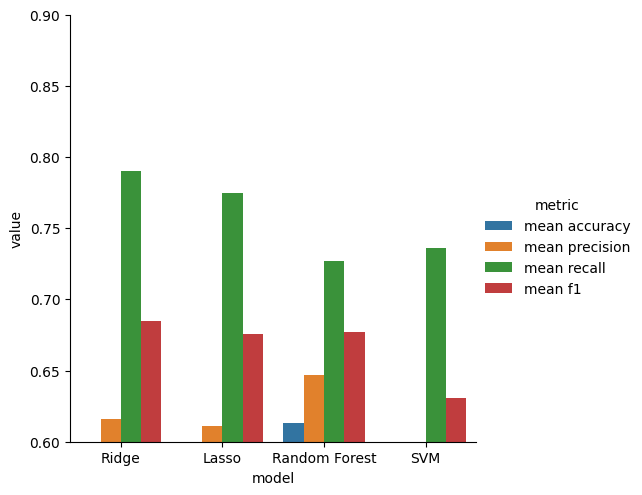

In [ ]:
#@title PLOTS: Train-test loop 2 performances w/ different models
#only works if train_test_loop returns metric values
stat_list = ['mean accuracy', 'mean precision', 'mean recall', 'mean f1']
stat_df = pd.DataFrame(columns = stat_list)
for i in model_list:
  print(i)
  dic = train_test_loop2(i, train_test_df.drop('mmse', axis = 1), train_idx, test_idx)[1]
  stat_df.loc[len(stat_df)] = dic
stat_df['model'] = ['Ridge', 'Lasso', 'Random Forest', 'SVM']


# Melt the DataFrame to long format
stat_df = pd.melt(stat_df, id_vars=['model'], value_vars=stat_list,
                  var_name='metric', value_name='value')

sns.catplot(stat_df, x = 'model', y = 'value', kind = 'bar', hue = 'metric')
plt.ylim(0.6,0.9)

In [ ]:
#@title OLD: Train-test loop 2 performances w/ different models
# for i in model_list:
#   print(i)
#   train_test_loop2(i, train_test_df, train_idx, test_idx)

{'mean accuracy': 0.7597, 'mean precision': 0.7789, 'mean recall': 0.8132, 'mean f1': 0.7902}
{'mean accuracy': 0.7822, 'mean precision': 0.8286, 'mean recall': 0.794, 'mean f1': 0.8066}
{'mean accuracy': 0.7594, 'mean precision': 0.79, 'mean recall': 0.8358, 'mean f1': 0.799}
{'mean accuracy': 0.7751, 'mean precision': 0.8073, 'mean recall': 0.7978, 'mean f1': 0.7995}
{'mean accuracy': 0.8209, 'mean precision': 0.8301, 'mean recall': 0.8705, 'mean f1': 0.8464}
{'mean accuracy': 0.7745, 'mean precision': 0.8082, 'mean recall': 0.8051, 'mean f1': 0.8032}
{'mean accuracy': 0.7594, 'mean precision': 0.7867, 'mean recall': 0.8512, 'mean f1': 0.8026}
{'mean accuracy': 0.8212, 'mean precision': 0.8385, 'mean recall': 0.8587, 'mean f1': 0.8449}


(0.6, 0.9)

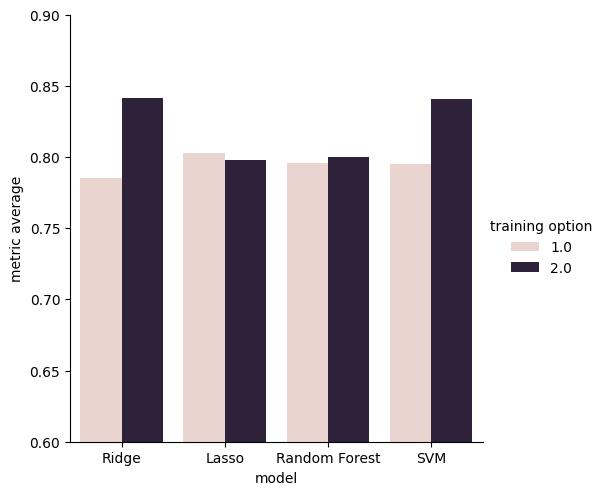

In [ ]:
#@title Train-test loop 1 vs. 2 performance

stat_df = pd.DataFrame(columns = ['metric average', 'training option'])
for i in model_list:
  avg = sum([i for i in train_test_loop1(i, train_test_df, train_idx, test_idx)[1].values()]) / 4
  stat_df.loc[len(stat_df)] = [avg, 1]

for i in model_list:
  avg = sum([i for i in train_test_loop2(i, train_test_df, train_idx, test_idx)[1].values()]) / 4
  stat_df.loc[len(stat_df)] = [avg, 2]

stat_df['model'] = ['Ridge', 'Lasso', 'Random Forest', 'SVM'] * 2

sns.catplot(stat_df, x = 'model', y = 'metric average', kind = 'bar', hue = 'training option')
plt.ylim(0.6,0.9)

## Feature / subset importances

In [ ]:
#@title OLD Train-test loop 1 function: no repeats in training data (aggregating training data and making a single prediction per patient)

def old_train_test_loop1(model_type_str, train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #aggregate training features and put them into a dictionary
    train_agg_dict, test_agg_dict = {}, {}

    for id in train_unique_ids:
      train_id_df = train_df_idx[train_df_idx['tkdname'] == id].drop(['tkdname'], axis = 1)
      for col in train_id_df.columns:
        if col != 'dx':
          if ('Mean ' + col) not in train_agg_dict:
            train_agg_dict['Mean ' + col] = []
          train_agg_dict['Mean ' + col].append(np.mean(train_id_df[col]))
        else:
          if col not in train_agg_dict:
            train_agg_dict[col] = []
          train_agg_dict['dx'].append(int(round(np.mean(train_id_df[col]))))

    for id in test_unique_ids:
      test_id_df = test_df_idx[test_df_idx['tkdname'] == id].drop(['tkdname'], axis = 1)
      for col in test_id_df.columns:
        if col != 'dx':
          if ('Mean ' + col) not in test_agg_dict:
            test_agg_dict['Mean ' + col] = []
          test_agg_dict['Mean ' + col].append(np.mean(test_id_df[col]))
        else:
          if col not in test_agg_dict:
            test_agg_dict[col] = []
          test_agg_dict['dx'].append(int(round(np.mean(test_id_df[col]))))

    train_agg_df, test_agg_df = pd.DataFrame(train_agg_dict), pd.DataFrame(test_agg_dict)

    #train a model to predict 'dx'

    X_train = train_agg_df.drop(['dx'], axis = 1)
    y_train = train_agg_df['dx']
    X_test = test_agg_df.drop(['dx'], axis = 1)
    y_test = test_agg_df['dx']

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = eval(model_type_str).fit(X_train, y_train)
    preds = model.predict(X_test)

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)
  #return best_model
  return best_model

In [ ]:
#@title OLD Train-test loop 2 function: no repeats in training data (aggregating multiple predictions for each patient)

def old_train_test_loop2(model_type_str, train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #train a model to predict 'dx'

    X_train = train_df_idx.drop(['dx', 'tkdname'], axis = 1)
    y_train = train_df_idx['dx']
    X_test = test_df_idx.drop(['dx', 'tkdname'], axis = 1)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = eval(model_type_str).fit(X_train, y_train)
    preds = model.predict(X_test)

    #aggregate predictions
    test_agg_df = test_df_idx[['tkdname','dx']].copy()
    test_agg_df['pred'] = preds
    test_agg_df = test_agg_df.groupby('tkdname').agg('mean')

    y_test = np.array(test_agg_df['dx'].apply(round).astype(int))
    preds = np.array(test_agg_df['pred'].apply(round).astype(int))

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)
  #return best_model
  return best_model

In [ ]:
#@title function that returns a train_test_df containing the features of the provided subsets (linguistic, acoustic, and or fluency)

def data_subset(train_subset_df_list, keep_cols = []):
  assert isinstance(train_subset_df_list, list)
  cols = []
  for df in train_subset_df_list:
    cols.extend(list(df.columns))
  return train_test_df[[col for col in train_test_df if (col in cols) or (col in keep_cols)]]

keep_cols = ['tkdname', 'mmse','dx']
data_subset([train_ac], keep_cols)

,tkdname,mmse,dx,Total Duration,Mean Pitch,Jitter,Shimmer
0,002,29,0,122.440000,164.242554,0.017773,0.088550
1,002,29,0,45.660000,162.687280,0.021281,0.098618
2,002,29,0,62.690000,179.818570,0.021813,0.098348
3,003,23,1,21.691521,111.579973,0.017167,0.098349
4,003,23,1,29.917625,114.257428,0.023902,0.140785
...,...,...,...,...,...,...,...
502,166,28,1,57.910000,174.392947,0.026509,0.144390
503,166,28,1,40.190000,182.735181,0.022918,0.120985
504,168,29,0,113.081167,107.070285,0.024537,0.098584
505,168,29,0,139.926437,107.509813,0.024251,0.103465


In [ ]:
#@title test performance on different subsets of the data

def report_combos(subset_dict, model_type_str, train_test_loop):
  combos = []
  for i in range(1, len(subset_dict) + 1):
    combos.extend(list(itertools.combinations(list(subset_dict.keys()), i)))
  combos = [list(i) for i in combos]

  for subset in combos:
    print(subset)
    subset = [subset_dict[i] for i in subset]
    train_test_loop(model_type_str, data_subset(subset, keep_cols), train_idx, test_idx)
    print('\n')

subset_dict = {'acoustic': train_ac, 'fluency': train_fl, 'linguistic': train_li}

report_combos(subset_dict, 'LogisticRegression()', train_test_loop2)

['acoustic']
{'mean accuracy': 0.7825, 'mean precision': 0.8331, 'mean recall': 0.7976, 'mean f1': 0.8056}


['fluency']
{'mean accuracy': 0.8058, 'mean precision': 0.8597, 'mean recall': 0.8123, 'mean f1': 0.8267}


['linguistic']
{'mean accuracy': 0.7668, 'mean precision': 0.8067, 'mean recall': 0.7976, 'mean f1': 0.7964}


['acoustic', 'fluency']
{'mean accuracy': 0.7822, 'mean precision': 0.8227, 'mean recall': 0.813, 'mean f1': 0.81}


['acoustic', 'linguistic']
{'mean accuracy': 0.7978, 'mean precision': 0.8343, 'mean recall': 0.8162, 'mean f1': 0.8196}


['fluency', 'linguistic']
{'mean accuracy': 0.7825, 'mean precision': 0.8208, 'mean recall': 0.8087, 'mean f1': 0.8086}


['acoustic', 'fluency', 'linguistic']
{'mean accuracy': 0.8209, 'mean precision': 0.8301, 'mean recall': 0.8705, 'mean f1': 0.8464}




In [ ]:
#@title test performance on different data subsets and model types

for i in model_list:
  print('-' * 20 + i + '-' * 20)
  report_combos(subset_dict, i, train_test_loop2)
  print('\n')

--------------------LogisticRegression()--------------------
['acoustic']
{'mean accuracy': 0.7591, 'mean precision': 0.8201, 'mean recall': 0.7711, 'mean f1': 0.7835}


['fluency']
{'mean accuracy': 0.7982, 'mean precision': 0.8323, 'mean recall': 0.8358, 'mean f1': 0.8261}


['linguistic']
{'mean accuracy': 0.7511, 'mean precision': 0.7949, 'mean recall': 0.7829, 'mean f1': 0.7811}


['acoustic', 'fluency']
{'mean accuracy': 0.7674, 'mean precision': 0.7946, 'mean recall': 0.8198, 'mean f1': 0.7996}


['acoustic', 'linguistic']
{'mean accuracy': 0.7591, 'mean precision': 0.7976, 'mean recall': 0.794, 'mean f1': 0.7891}


['fluency', 'linguistic']
{'mean accuracy': 0.728, 'mean precision': 0.7587, 'mean recall': 0.791, 'mean f1': 0.7669}


['acoustic', 'fluency', 'linguistic']
{'mean accuracy': 0.7597, 'mean precision': 0.7789, 'mean recall': 0.8132, 'mean f1': 0.7902}




--------------------LogisticRegression(penalty = 'l1', solver = 'liblinear')--------------------
['acoustic']
{'m

In [ ]:
#@title subset_feature_dict

subset_feature_dict = {'tkdname': 'none', 'mmse': 'none', 'dx': 'none'}
for subset_item in list(subset_dict.items()):
  for i in list(subset_item[1].columns):
    subset_feature_dict[i] = subset_item[0]

subset_feature_dict

{'tkdname': 'none',
 'mmse': 'none',
 'dx': 'none',
 'File': 'linguistic',
 'Total Duration': 'acoustic',
 'Mean Pitch': 'acoustic',
 'Jitter': 'acoustic',
 'Shimmer': 'acoustic',
 'target': 'linguistic',
 'Filler Rate': 'fluency',
 'General Silence': 'fluency',
 'Mean Silence': 'fluency',
 'Silence Abs Deviation': 'fluency',
 'Silence Rate 1': 'fluency',
 'Silence Rate 2': 'fluency',
 'Speaking Rate': 'fluency',
 'Articulate Rate': 'fluency',
 'Avg.syllables in words': 'fluency',
 'Word syllables 2': 'fluency',
 'Repetition Frequency': 'fluency',
 'Unique Word Count': 'linguistic',
 'Invented Word Count': 'linguistic',
 'Total Adjectives': 'linguistic',
 'Total Adverbs': 'linguistic',
 'Total Nouns': 'linguistic',
 'Total Verbs': 'linguistic',
 'Total Pronouns': 'linguistic',
 'Total Conjunction': 'linguistic',
 'Depth of Syntax Tree': 'linguistic'}

In [ ]:
#@title Bar Plot Function for feature importances

color_dict = {'none':'blue', 'linguistic':'red', 'acoustic':'orange', 'fluency':'green'}

def bar_plot_importances(train_subset_df_list, feature_importances, func = lambda x: x, n = 10):
  feature_names = data_subset(train_subset_df_list, ['mmse']).columns
  feature_importance_df = pd.DataFrame({
      'Feature': feature_names,
      'Importance': feature_importances
  })
  feature_importance_df['Importance'] = func(feature_importance_df['Importance'])

  top_10_features = feature_importance_df.sort_values(by = ['Importance'], ascending = False, key = abs).head(n)
  top_10_features['Subset'] = top_10_features['Feature'].map(lambda x: subset_feature_dict[x])
  sns.barplot(x='Importance', y='Feature', hue = 'Subset', data=top_10_features, palette = color_dict)
  plt.show()

#bar_plot_importances([train_test_df.drop(['dx', 'tkdname'], axis = 1)], train_test_loop1('LogisticRegression()', train_test_df, train_idx, test_idx).coef_[0])

LogisticRegression():
{'mean accuracy': 0.5889, 'mean precision': 0.6162, 'mean recall': 0.7903, 'mean f1': 0.6851}


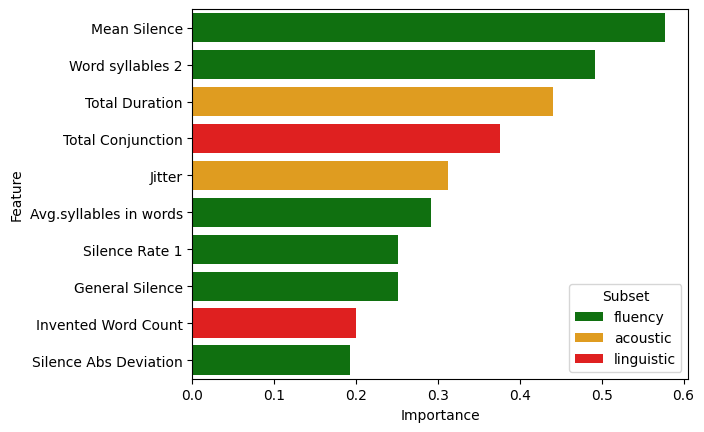

LogisticRegression(penalty = 'l1', solver = 'liblinear'):
{'mean accuracy': 0.5812, 'mean precision': 0.611, 'mean recall': 0.775, 'mean f1': 0.6759}


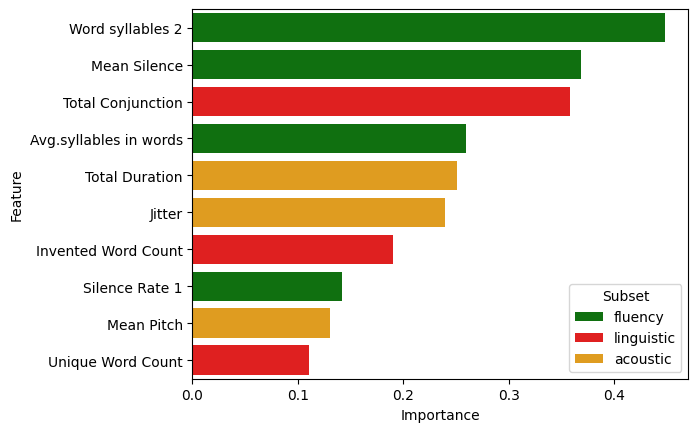

RandomForestClassifier():
{'mean accuracy': 0.6055, 'mean precision': 0.6471, 'mean recall': 0.6813, 'mean f1': 0.6588}


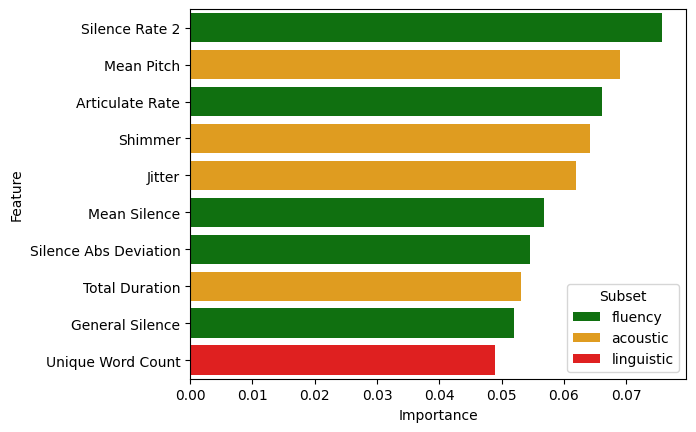

svm.SVC(kernel = 'linear'):
{'mean accuracy': 0.512, 'mean precision': 0.5712, 'mean recall': 0.736, 'mean f1': 0.631}


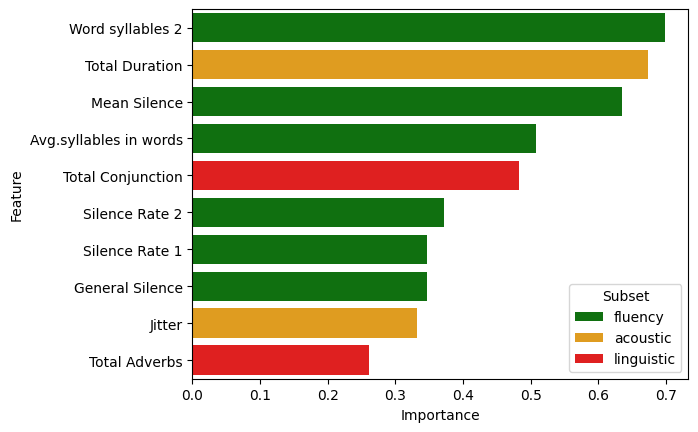

In [ ]:
#@title Bar Plot Function for feature importances WITHOUT MMSE

color_dict = {'none':'blue', 'linguistic':'red', 'acoustic':'orange', 'fluency':'green'}

def bar_plot_importances2(train_subset_df_list, feature_importances, func = lambda x: x, n = 10):
  feature_names = data_subset(train_subset_df_list).columns
  feature_importance_df = pd.DataFrame({
      'Feature': feature_names,
      'Importance': feature_importances
  })
  feature_importance_df['Importance'] = func(feature_importance_df['Importance'])

  top_10_features = feature_importance_df.sort_values(by = ['Importance'], ascending = False, key = abs).head(n)
  top_10_features['Subset'] = top_10_features['Feature'].map(lambda x: subset_feature_dict[x])
  sns.barplot(x='Importance', y='Feature', hue = 'Subset', data=top_10_features, palette = color_dict)
  plt.show()

for i in range(len(model_list)):
  print(model_list[i] + ':')
  bar_plot_importances2([train_test_df.drop(['dx', 'tkdname', 'mmse'], axis = 1)],
                       eval("old_train_test_loop2(model_list[i], train_test_df.drop('mmse', axis = 1), train_idx, test_idx)" + imp_str_list[i]), func = abs)

LogisticRegression():
{'mean accuracy': 0.8209, 'mean precision': 0.8301, 'mean recall': 0.8705, 'mean f1': 0.8464}


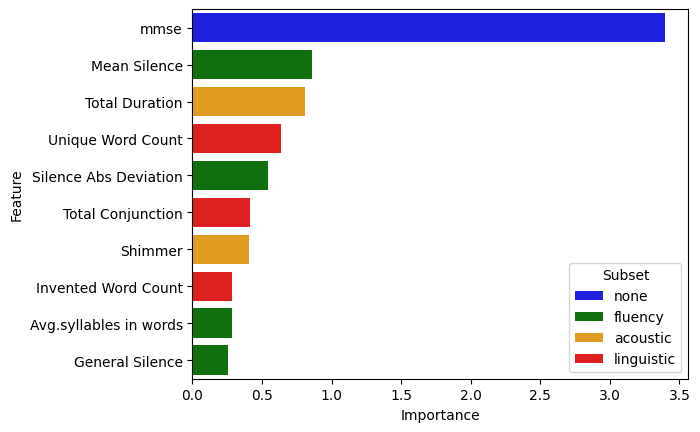

LogisticRegression(penalty = 'l1', solver = 'liblinear'):
{'mean accuracy': 0.7745, 'mean precision': 0.8082, 'mean recall': 0.8051, 'mean f1': 0.8032}


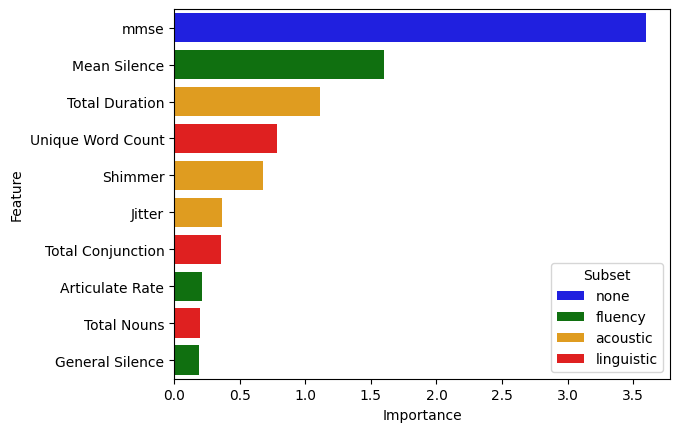

RandomForestClassifier():
{'mean accuracy': 0.7751, 'mean precision': 0.7998, 'mean recall': 0.8623, 'mean f1': 0.8161}


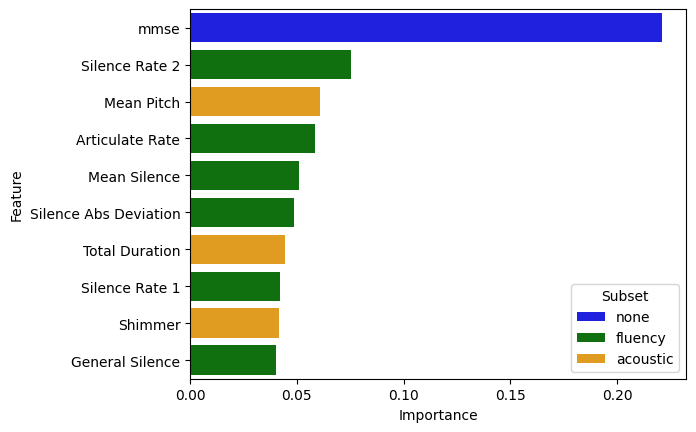

svm.SVC(kernel = 'linear'):
{'mean accuracy': 0.8212, 'mean precision': 0.8385, 'mean recall': 0.8587, 'mean f1': 0.8449}


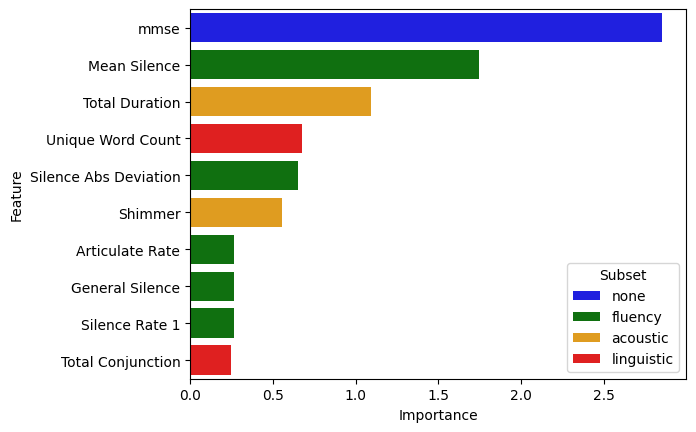

In [ ]:
#@title Create bar plots for the feature importances of different model types (abs)

#change SVC to a linear kernel version so we can extract feature importances
model_list[3] = "svm.SVC(kernel = 'linear')"

for i in range(len(model_list)):
  print(model_list[i] + ':')
  bar_plot_importances([train_test_df.drop(['dx', 'tkdname'], axis = 1)],
                       eval("old_train_test_loop2(model_list[i], train_test_df, train_idx, test_idx)" + imp_str_list[i]), func = abs)

LogisticRegression():
{'mean accuracy': 0.8209, 'mean precision': 0.8301, 'mean recall': 0.8705, 'mean f1': 0.8464}


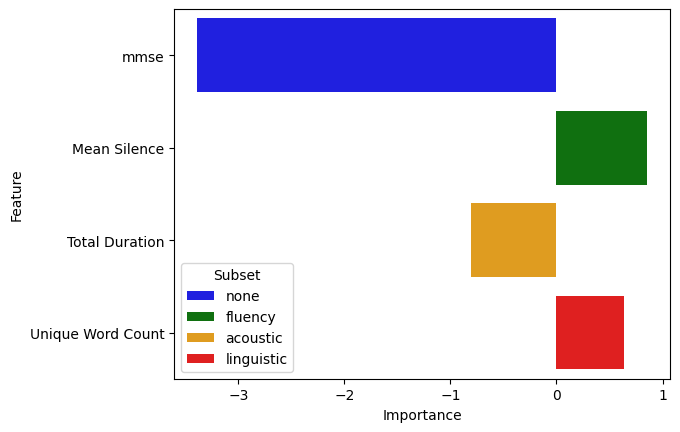

LogisticRegression(penalty = 'l1', solver = 'liblinear'):
{'mean accuracy': 0.7745, 'mean precision': 0.8082, 'mean recall': 0.8051, 'mean f1': 0.8032}


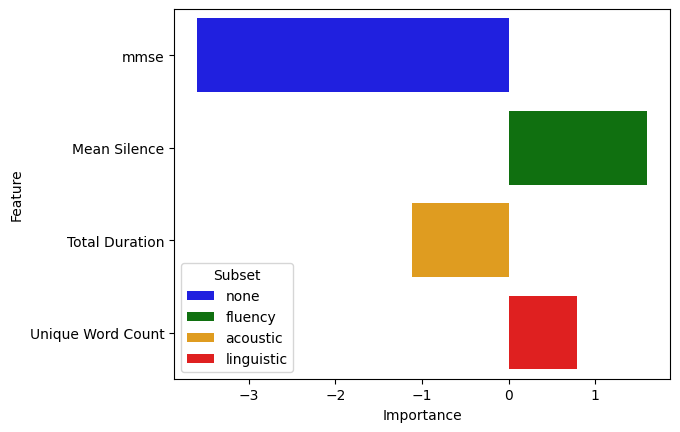

RandomForestClassifier():
{'mean accuracy': 0.7751, 'mean precision': 0.7795, 'mean recall': 0.8895, 'mean f1': 0.8178}


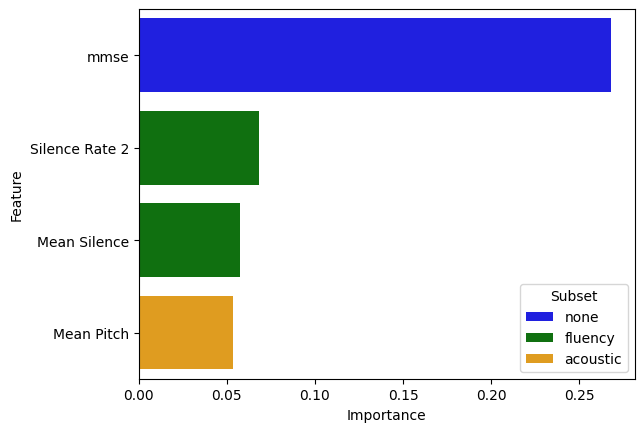

svm.SVC(kernel = 'linear'):
{'mean accuracy': 0.8212, 'mean precision': 0.8385, 'mean recall': 0.8587, 'mean f1': 0.8449}


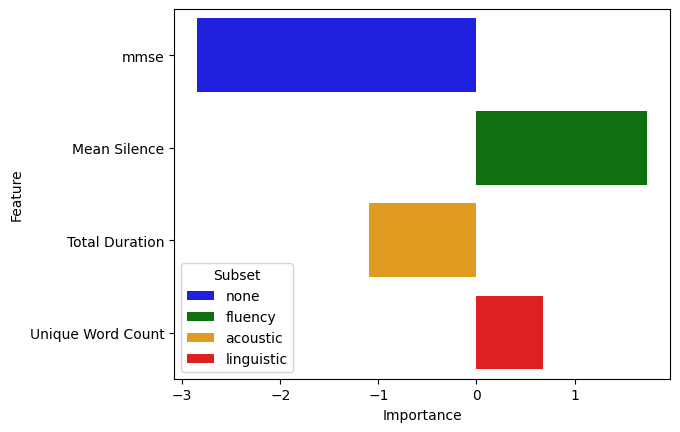

In [ ]:
#@title Create bar plots for the feature importances of different model types (not abs)

#change SVC to a linear kernel version so we can extract feature importances
model_list[3] = "svm.SVC(kernel = 'linear')"

for i in range(len(model_list)):
  print(model_list[i] + ':')
  bar_plot_importances([train_test_df.drop(['dx', 'tkdname'], axis = 1)],
                       eval("old_train_test_loop2(model_list[i], train_test_df, train_idx, test_idx)" + imp_str_list[i]), n = 4)

LogisticRegression():
mean accuracy: 0.8058, mean precision: 0.8279, mean recall: 0.8433, mean f1: 0.8304


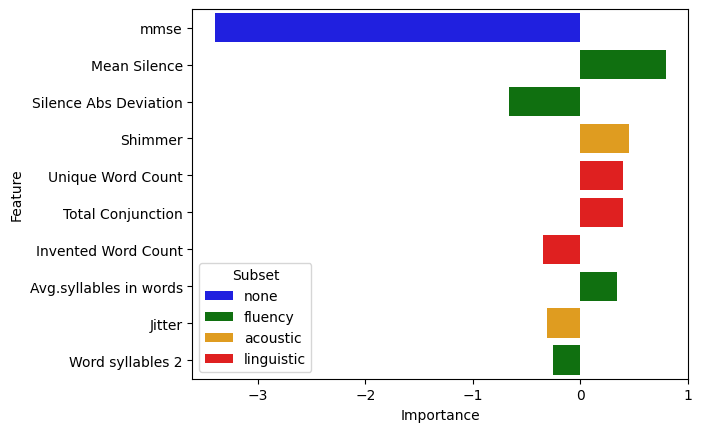

LogisticRegression(penalty = 'l1', solver = 'liblinear'):
mean accuracy: 0.7748, mean precision: 0.8090, mean recall: 0.8051, mean f1: 0.8019


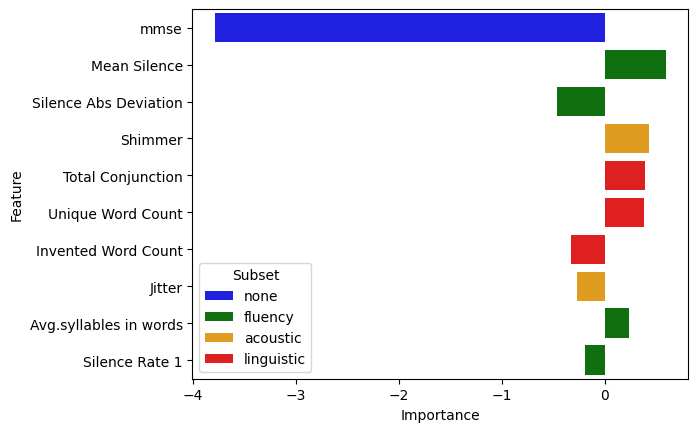

RandomForestClassifier():
mean accuracy: 0.7905, mean precision: 0.8208, mean recall: 0.8623, mean f1: 0.8281


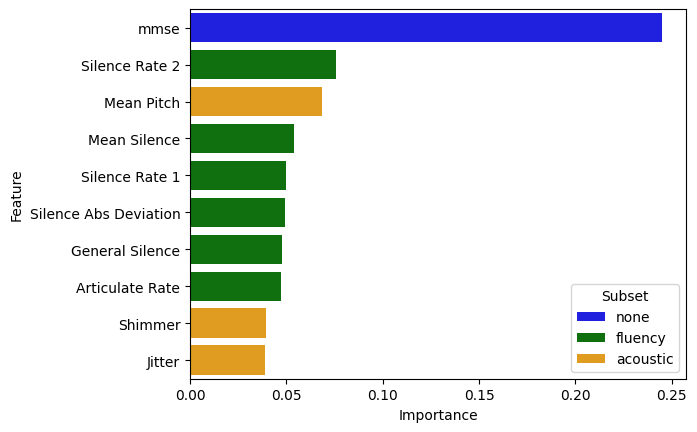

In [ ]:
#@title Feature importances of different model types (without duration column)


for i in range(len(model_list[:3])):
  print(model_list[i] + ':')
  bar_plot_importances([train_test_df.drop(['dx', 'tkdname', 'Total Duration'], axis = 1)],
                       eval("train_test_loop2(model_list[i], train_test_df.drop('Total Duration', axis = 1), train_idx, test_idx)" + imp_str_list[i]))

In [ ]:
#@title 3d Plot for Important Features
# Define a threshold to identify outliers
threshold = train_test_df['Avg.syllables in words'].quantile(0.95)  # For example, keep only the bottom 95%

# Filter the DataFrame to exclude outliers
filtered_df = train_test_df[train_test_df['Avg.syllables in words'] < threshold]

#filtered_df = train_test_df

fig = px.scatter_3d(filtered_df, x='mmse', y='Total Conjunction', z='Avg.syllables in words',
              color='dx')
fig.show()

In [ ]:
#@title SHAP 1 for Lasso Logistic Regression

def shap_train_test_loop1(model_type_str, train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #aggregate training features and put them into a dictionary
    train_agg_dict, test_agg_dict = {}, {}

    for id in train_unique_ids:
      train_id_df = train_df_idx[train_df_idx['tkdname'] == id].drop(['tkdname'], axis = 1)
      for col in train_id_df.columns:
        if col != 'dx':
          if ('Mean ' + col) not in train_agg_dict:
            train_agg_dict['Mean ' + col] = []
          train_agg_dict['Mean ' + col].append(np.mean(train_id_df[col]))
        else:
          if col not in train_agg_dict:
            train_agg_dict[col] = []
          train_agg_dict['dx'].append(int(round(np.mean(train_id_df[col]))))

    for id in test_unique_ids:
      test_id_df = test_df_idx[test_df_idx['tkdname'] == id].drop(['tkdname'], axis = 1)
      for col in test_id_df.columns:
        if col != 'dx':
          if ('Mean ' + col) not in test_agg_dict:
            test_agg_dict['Mean ' + col] = []
          test_agg_dict['Mean ' + col].append(np.mean(test_id_df[col]))
        else:
          if col not in test_agg_dict:
            test_agg_dict[col] = []
          test_agg_dict['dx'].append(int(round(np.mean(test_id_df[col]))))

    train_agg_df, test_agg_df = pd.DataFrame(train_agg_dict), pd.DataFrame(test_agg_dict)

    #train a model to predict 'dx'

    X_train = train_agg_df.drop(['dx'], axis = 1)
    y_train = train_agg_df['dx']
    X_test = test_agg_df.drop(['dx'], axis = 1)
    y_test = test_agg_df['dx']

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = eval(model_type_str).fit(X_train, y_train)
    preds = model.predict(X_test)

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  print(f'mean accuracy: {np.mean(accs):.4f}, mean precision: {np.mean(precs):.4f}, mean recall: {np.mean(recas):.4f}, mean f1: {np.mean(f1s):.4f}')

  shap.initjs()

  explainer = shap.Explainer(
      best_model, X_train, feature_names=list(train_test_df.drop(['dx', 'tkdname'], axis = 1).columns)
  )
  shap_values = explainer(X_test)
  display(shap.plots.beeswarm(shap_values))
  display(shap.plots.bar(shap_values))

  return(best_model)

In [ ]:
#@title SHAP 2 for Lasso Logistic Regression

def shap_train_test_loop2(model_type_str, train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #train a model to predict 'dx'

    X_train = train_df_idx.drop(['dx', 'tkdname'], axis = 1)
    y_train = train_df_idx['dx']
    X_test = test_df_idx.drop(['dx', 'tkdname'], axis = 1)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = eval(model_type_str).fit(X_train, y_train)
    preds = model.predict(X_test)

    #aggregate predictions
    test_agg_df = test_df_idx[['tkdname','dx']].copy()
    test_agg_df['pred'] = preds
    test_agg_df = test_agg_df.groupby('tkdname').agg(np.mean)

    y_test = np.array(test_agg_df['dx'].apply(round).astype(int))
    preds = np.array(test_agg_df['pred'].apply(round).astype(int))

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)

  shap.initjs()

  explainer = shap.Explainer(
      best_model, X_train, feature_names=list(train_test_df.drop(['dx', 'tkdname'], axis = 1).columns)
  )
  shap_values = explainer(X_test)
  display(shap.plots.beeswarm(shap_values))
  display(shap.plots.bar(shap_values))

  return best_model

{'mean accuracy': 0.8209, 'mean precision': 0.8301, 'mean recall': 0.8705, 'mean f1': 0.8464}


<ipython-input-43-e6fdcc0e34b2>:32: FutureWarning: The provided callable <function mean at 0x7a6db6917d90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  test_agg_df = test_agg_df.groupby('tkdname').agg(np.mean)
<ipython-input-43-e6fdcc0e34b2>:32: FutureWarning: The provided callable <function mean at 0x7a6db6917d90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  test_agg_df = test_agg_df.groupby('tkdname').agg(np.mean)
<ipython-input-43-e6fdcc0e34b2>:32: FutureWarning: The provided callable <function mean at 0x7a6db6917d90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  test_agg_df = test_agg_df.groupb

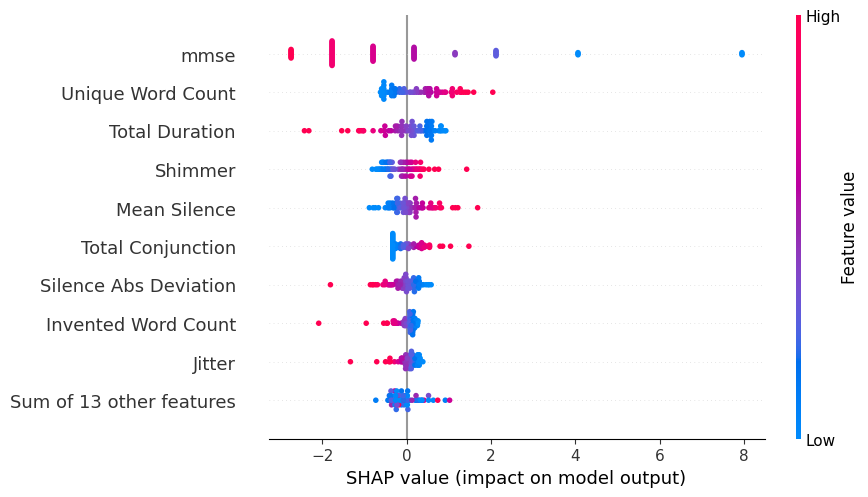

None

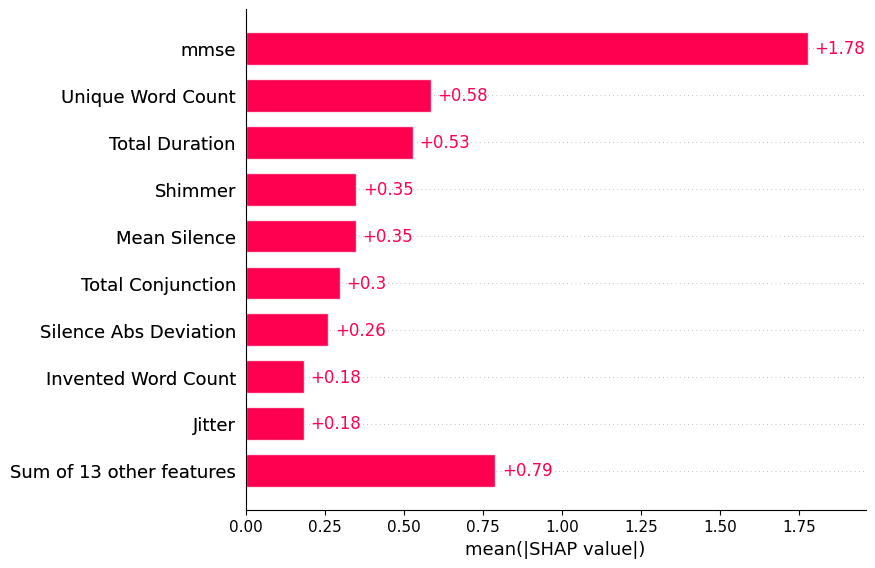

None

LogisticRegression()

In [ ]:
shap_train_test_loop2(model_list[0], train_test_df, train_idx, test_idx)

## Misc

In [ ]:
#@title KNN

train_test_loop2('KNeighborsClassifier(n_neighbors = 3)', train_test_df, train_idx, test_idx)

mean accuracy: 0.6895, mean precision: 0.7529, mean recall: 0.7089, mean f1: 0.7239


KNeighborsClassifier(n_neighbors=3)

In [ ]:
#@title Check for Outliers
num_df = train_test_df.drop(['dx', 'tkdname'], axis = 1)
for i in num_df.columns:
  q1 = num_df[i].quantile(0.25)
  q3 = num_df[i].quantile(0.75)
  iqr = q1 - q1

  threshold = 1.5
  outliers = num_df[(num_df[i] < q1 - threshold * iqr) | (num_df[i] > q3 + threshold * iqr)][i]
  print(i + ':')
  print(np.array(num_df[i]))
  print(np.array(outliers))
  print('\n')
  #display(num_df[[i]])
  #display(outliers)

mmse:
[29 29 29 23 23 23 29 29 29 29 29 29 26 26 26 29 29 29 29 29 29 23 23 23
 25 25 25 29 29 29 27 27 27 29 29 29 27 27 27 28 28 28 26 26 26 16 16 16
 29 29 29 27 27 27 30 30 30 29 29 29 27 27 27 29 29 29 28 28 28 27 27 27
 29 29 29 25 25 25 29 29 29 27 27 27 27 27 27 28 28 28 30 30 30 29 29 29
 30 30 30 26 26 26 27 27 27 27 27 27 25 25 25 29 29 29 28 28 28 30 30 30
 29 29 29 27 27 27 30 30 30 17 17 17 30 30 30 29 29 29 30 30 30 28 28 28
 21 21 21 30 30 30 29 29 29 27 27 27 29 29 29 29 29 29 26 26 26 23 23 23
 19 19 19 27 27 27 28 28 28 26 26 26 30 30 30 29 29 29 30 30 30 28 28 28
 29 29 29 27 27 27 30 30 30 27 27 27 24 24 24 18 18 18 24 24 24 29 29 29
 30 30 30 29 29 29 29 29 29 29 29 29 20 20 20 30 30 30 30 30 30 25 25 25
 28 28 28 27 27 27 25 25 25 27 27 27 29 29 29 28 28 28 29 29 29 29 29 29
 29 29 29 27 27 27 30 30 30 16 16 16 28 28 28 25 25 25 28 28 28 30 30 30
 29 29 29 24 24 24 30 30 30 28 28 28 30 30 30 28 28 28 19 19 19 28 28 28
 28 28 28 30 30 30 25 25 25 30 30 30 27 27 27

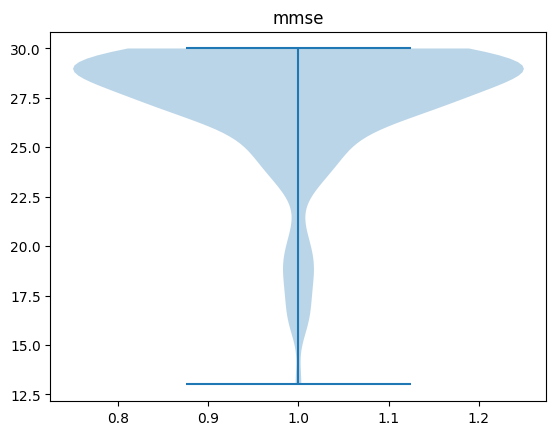

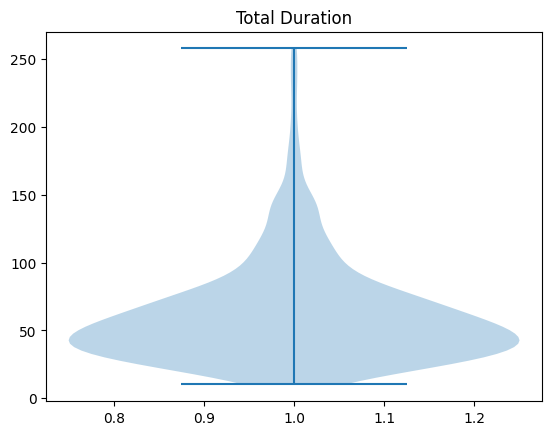

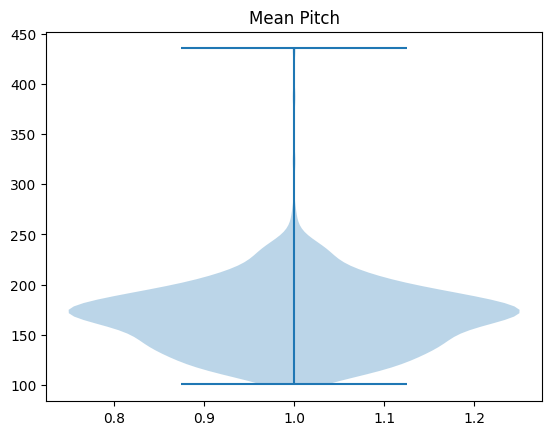

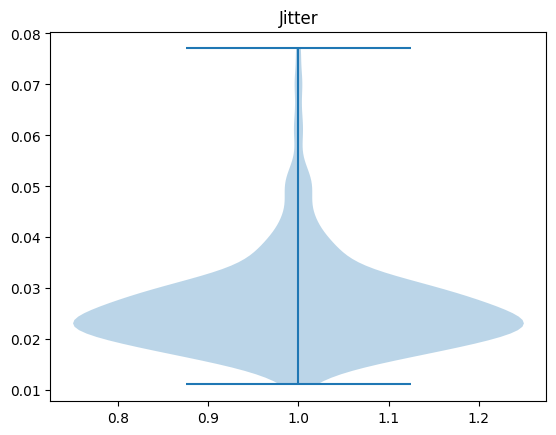

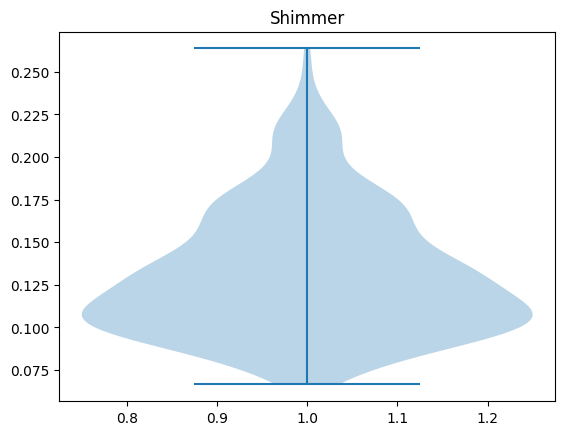

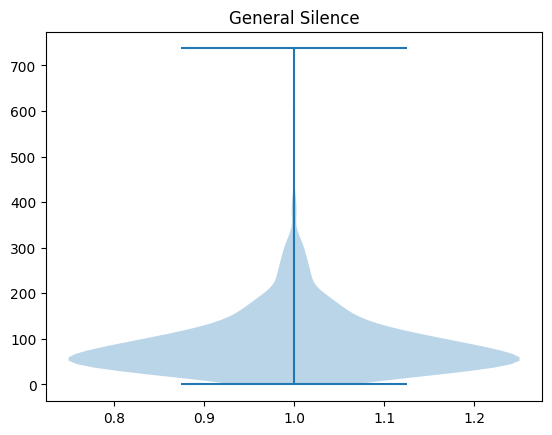

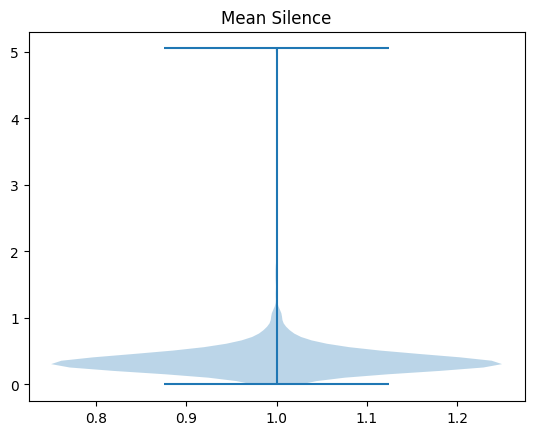

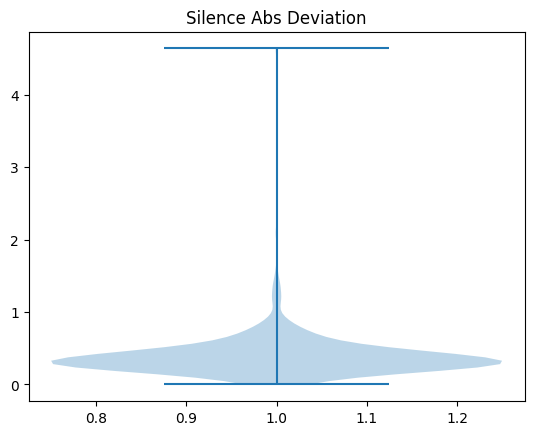

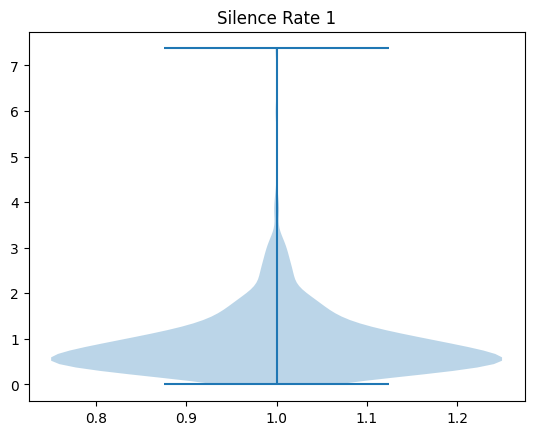

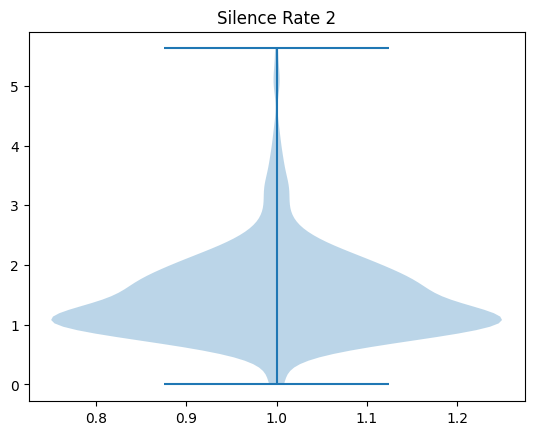

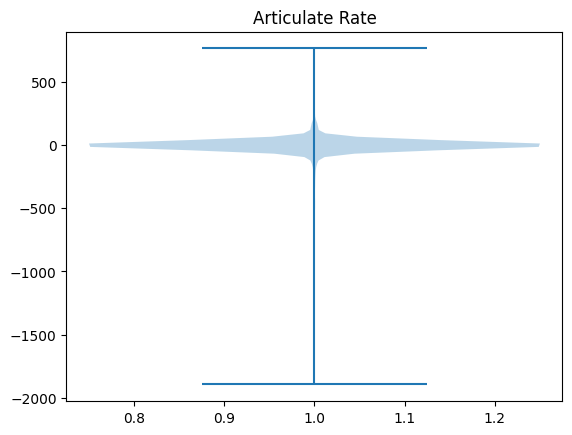

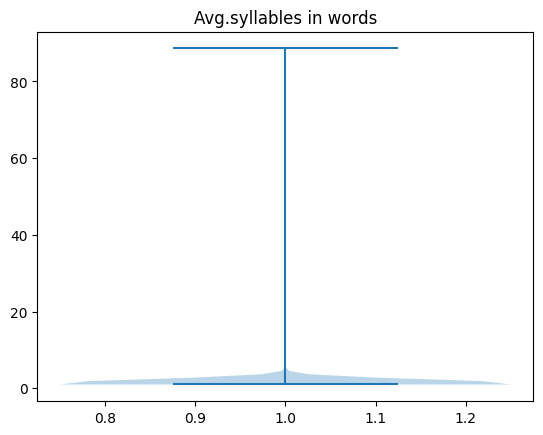

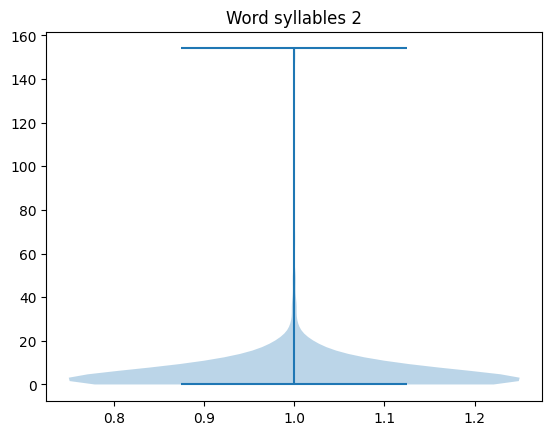

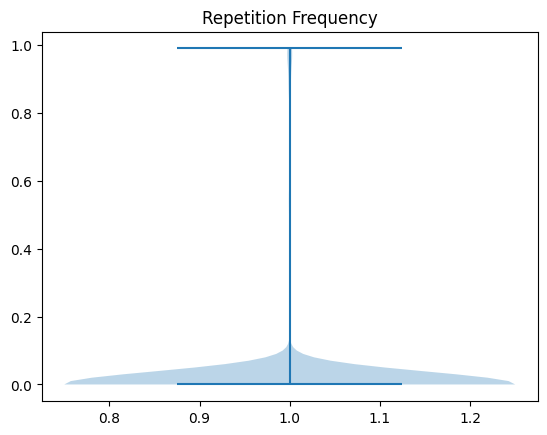

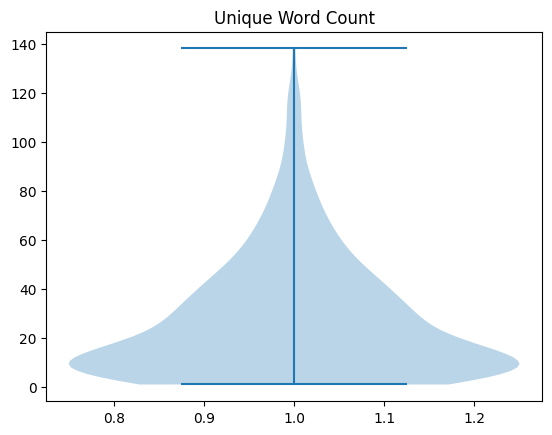

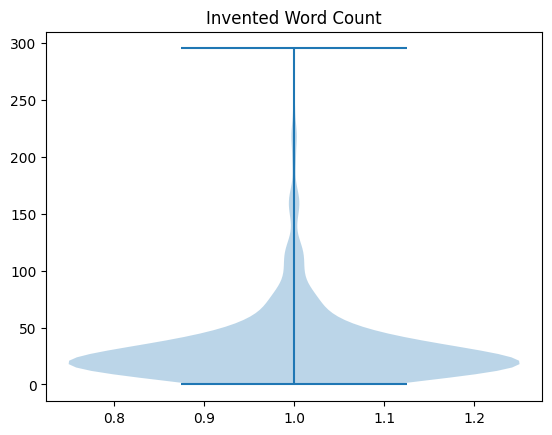

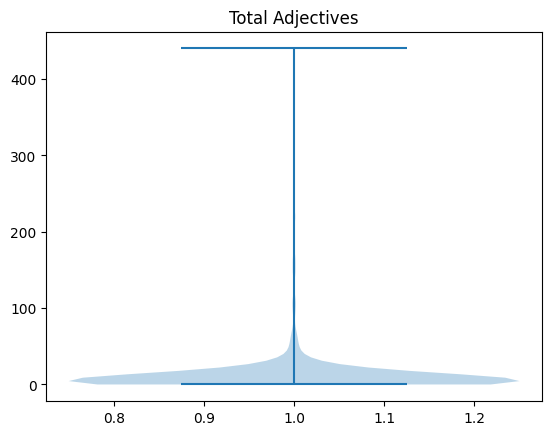

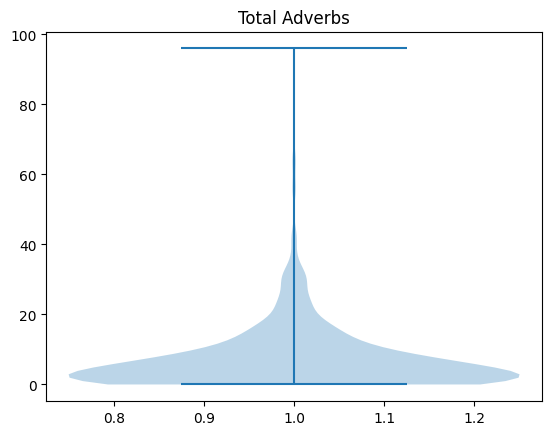

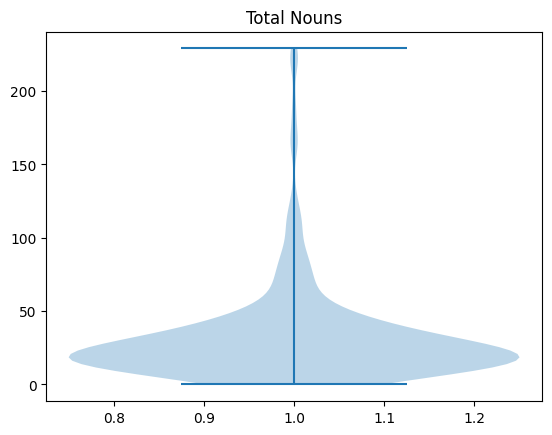

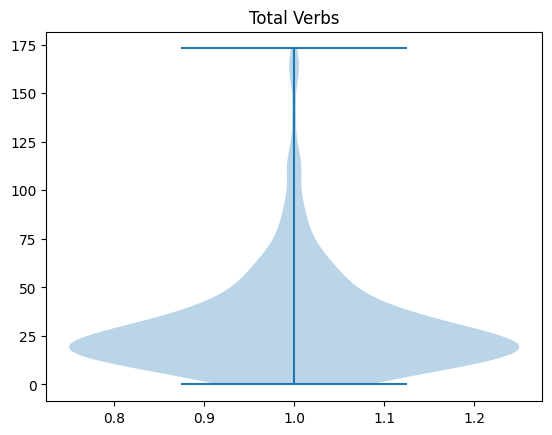

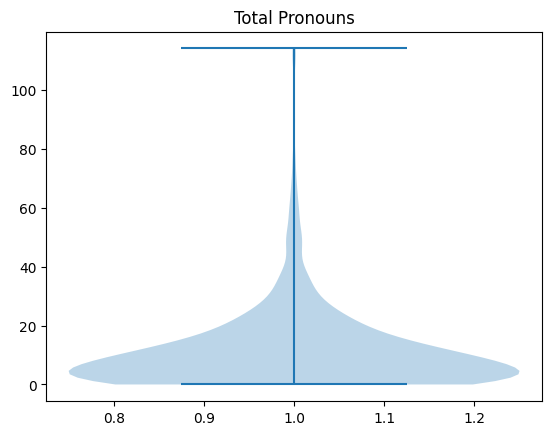

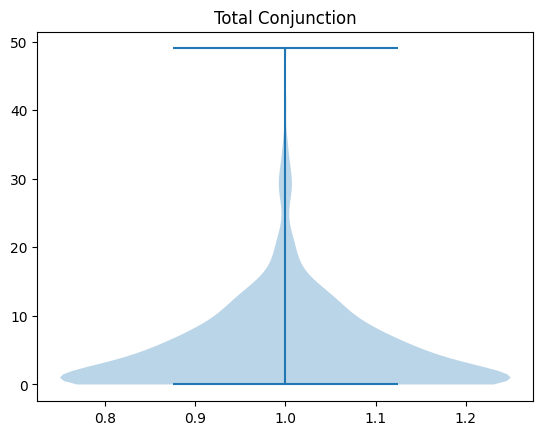

In [ ]:
#@title Distribution of Each Variable
for i in train_test_df.drop(['dx', 'tkdname'], axis = 1).columns:
  plt.figure()
  plt.violinplot(train_test_df[i])
  plt.title(i)
  plt.show()

In [ ]:
#@title ensemble loop function: train_test_loop_2
#ensemble the predictions of Ridge, Random Forest, and SVM

def ensemble_loop(train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #train a model to predict 'dx'

    X_train = train_df_idx.drop(['dx', 'tkdname'], axis = 1)
    y_train = train_df_idx['dx']
    X_test = test_df_idx.drop(['dx', 'tkdname'], axis = 1)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    preds = []
    for i in (model_list[:0] + model_list[2:]):
      model = eval(i).fit(X_train, y_train)
      preds.append(model.predict(X_test))

    preds = (np.mean(np.array(preds), axis = 0) >= 0.5).astype(int)

    #aggregate predictions
    test_agg_df = test_df_idx[['tkdname','dx']].copy()
    test_agg_df['pred'] = preds
    test_agg_df = test_agg_df.groupby('tkdname').agg('mean')

    y_test = np.array(test_agg_df['dx'].apply(round).astype(int))
    preds = np.array(test_agg_df['pred'].apply(round).astype(int))

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)
  #return best_model
  return best_model, scores

In [ ]:
ensemble_loop(train_test_df, train_idx, test_idx)

{'mean accuracy': 0.7828, 'mean precision': 0.7661, 'mean recall': 0.9124, 'mean f1': 0.8262}


(SVC(kernel='linear'),
 {'mean accuracy': 0.7828,
  'mean precision': 0.7661,
  'mean recall': 0.9124,
  'mean f1': 0.8262})

In [ ]:
#@title Find best C (1 / lambda) for Lasso
cs = 1 / np.logspace(-4, 4, 20)
vals = {}
for i in cs:
  vals[i] = train_test_loop2("LogisticRegression(penalty = 'l1', solver = 'liblinear', C = i)", train_test_df, train_idx, test_idx)[1]['mean accuracy']
vals

{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8366, 'mean precision': 0.8592, 'mean recall': 0.8551, 'mean f1': 0.8559}
{'mean accuracy': 0.8209, 'mean precision': 0.8375, 'mean recall': 0.8551, 'mean f1': 0.8449}
{'mean accuracy': 0.7978, 'mean precision': 0.8224, 'mean recall': 0.828, 'mean f1': 0.8232}
{'mean accuracy': 0.7745, 'mean precision': 0.8082, 'mean rec

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

{'mean accuracy': 0.4812, 'mean precision': 0.1778, 'mean recall': 0.0889, 'mean f1': 0.1185}
{'mean accuracy': 0.4252, 'mean precision': 0.0, 'mean recall': 0.0, 'mean f1': 0.0}
{'mean accuracy': 0.4252, 'mean precision': 0.0, 'mean recall': 0.0, 'mean f1': 0.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

{'mean accuracy': 0.4252, 'mean precision': 0.0, 'mean recall': 0.0, 'mean f1': 0.0}
{'mean accuracy': 0.4252, 'mean precision': 0.0, 'mean recall': 0.0, 'mean f1': 0.0}
{'mean accuracy': 0.4252, 'mean precision': 0.0, 'mean recall': 0.0, 'mean f1': 0.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

{10000.0: 0.8366,
 3792.6901907322494: 0.8366,
 1438.449888287663: 0.8366,
 545.559478116852: 0.8366,
 206.91380811147903: 0.8366,
 78.47599703514615: 0.8366,
 29.76351441631319: 0.8366,
 11.288378916846895: 0.8366,
 4.281332398719396: 0.8209,
 1.6237767391887226: 0.7978,
 0.6158482110660267: 0.7745,
 0.23357214690901212: 0.7668,
 0.08858667904100832: 0.7748,
 0.033598182862837875: 0.7043,
 0.012742749857031348: 0.4812,
 0.004832930238571753: 0.4252,
 0.0018329807108324375: 0.4252,
 0.0006951927961775619: 0.4252,
 0.0002636650898730361: 0.4252,
 0.0001: 0.4252}

In [ ]:
#@title Find best C (1 / lambda) for SVM
cs = 1 / np.logspace(-4, 4, 20)
vals = {}
for i in cs:
  vals[i] = train_test_loop2("svm.SVC(C = i)", train_test_df, train_idx, test_idx)[1]['mean accuracy']
vals

{'mean accuracy': 0.6822, 'mean precision': 0.7106, 'mean recall': 0.7399, 'mean f1': 0.7216}
{'mean accuracy': 0.6822, 'mean precision': 0.7106, 'mean recall': 0.7399, 'mean f1': 0.7216}
{'mean accuracy': 0.6822, 'mean precision': 0.7106, 'mean recall': 0.7399, 'mean f1': 0.7216}
{'mean accuracy': 0.7132, 'mean precision': 0.746, 'mean recall': 0.7553, 'mean f1': 0.747}
{'mean accuracy': 0.7209, 'mean precision': 0.7455, 'mean recall': 0.7671, 'mean f1': 0.7523}
{'mean accuracy': 0.744, 'mean precision': 0.7839, 'mean recall': 0.7707, 'mean f1': 0.7745}
{'mean accuracy': 0.7902, 'mean precision': 0.8555, 'mean recall': 0.77, 'mean f1': 0.8095}
{'mean accuracy': 0.7748, 'mean precision': 0.8391, 'mean recall': 0.7583, 'mean f1': 0.7932}
{'mean accuracy': 0.7514, 'mean precision': 0.8008, 'mean recall': 0.7589, 'mean f1': 0.7768}
{'mean accuracy': 0.7671, 'mean precision': 0.7972, 'mean recall': 0.8132, 'mean f1': 0.8001}
{'mean accuracy': 0.736, 'mean precision': 0.767, 'mean recall': 

{10000.0: 0.6822,
 3792.6901907322494: 0.6822,
 1438.449888287663: 0.6822,
 545.559478116852: 0.7132,
 206.91380811147903: 0.7209,
 78.47599703514615: 0.744,
 29.76351441631319: 0.7902,
 11.288378916846895: 0.7748,
 4.281332398719396: 0.7514,
 1.6237767391887226: 0.7671,
 0.6158482110660267: 0.736,
 0.23357214690901212: 0.6437,
 0.08858667904100832: 0.5668,
 0.033598182862837875: 0.5748,
 0.012742749857031348: 0.5748,
 0.004832930238571753: 0.5748,
 0.0018329807108324375: 0.5748,
 0.0006951927961775619: 0.5748,
 0.0002636650898730361: 0.5748,
 0.0001: 0.5748}

In [ ]:
#@title RandomForest tuning w/ train-test loop 1 function

from sklearn.model_selection import train_test_split, RandomizedSearchCV

def rf_tune(train_test_df, train_idx, test_idx):
  best_model = None
  best_acc = None
  accs, precs, recas, f1s = [], [], [], []
  for fold in range(5):

    #extract a single fold of training / testing data
    train_df_idx = train_test_df[train_test_df['tkdname'].isin(train_idx[fold])]
    test_df_idx = train_test_df[train_test_df['tkdname'].isin(test_idx[fold])]
    train_unique_ids = np.unique(train_df_idx['tkdname'])
    test_unique_ids = np.unique(test_df_idx['tkdname'])

    #train a model to predict 'dx'

    X_train = train_df_idx.drop(['dx', 'tkdname'], axis = 1)
    y_train = train_df_idx['dx']
    X_test = test_df_idx.drop(['dx', 'tkdname'], axis = 1)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
    }

    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)

    # Initialize the RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist)

    # Fit the model
    rf_random.fit(X_train, y_train)

    # Get the best model
    model = rf_random.best_estimator_

    preds = model.predict(X_test)

    #aggregate predictions
    test_agg_df = test_df_idx[['tkdname','dx']].copy()
    test_agg_df['pred'] = preds
    test_agg_df = test_agg_df.groupby('tkdname').agg(np.mean)

    y_test = np.array(test_agg_df['dx'].apply(round).astype(int))
    preds = np.array(test_agg_df['pred'].apply(round).astype(int))

    #evaluate and print the model's average performance on the testing data over 5 trials

    accs.append(accuracy_score(y_test, preds))
    precs.append(precision_score(y_test, preds))
    recas.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

    mean_accs = np.mean([ls[-1] for ls in [accs, precs, recas, f1s]])

    if (best_model and mean_accs > best_acc) or not best_model:
      best_model = model
      best_acc = mean_accs

  scores = [np.round(np.mean(accs), 4), np.round(np.mean(precs), 4), np.round(np.mean(recas), 4), np.round(np.mean(f1s), 4)]
  scores = {'mean accuracy': scores[0], 'mean precision': scores[1], 'mean recall': scores[2], 'mean f1': scores[3]}

  #print(f'mean accuracy: {scores[0]}, mean precision: {scores[1]}, mean recall: {scores[2]}, mean f1: {scores[3]}')
  print(scores)
  #return best_model
  return best_model, scores

#rf_tune(train_test_df, train_idx, test_idx)